In [ ]:
# @title 0) Mount Google Drive & set folder proyek

from google.colab import drive
drive.mount('/content/drive')

import os, json
from datetime import datetime
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

# Folder kerja di Google Drive (silakan sesuaikan)
BASE_DIR = "/content/drive/MyDrive/DataMining2025"
os.makedirs(BASE_DIR, exist_ok=True)

# Nama file input/output (ubah kalau perlu)
INPUT_FILE   = os.path.join(BASE_DIR, "heart.csv")        # nama file dataset asli
OUTPUT_CLEAN = os.path.join(BASE_DIR, "heart_clean.csv")  # output dataset bersih
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

print("BASE_DIR      :", BASE_DIR)
print("INPUT_FILE    :", INPUT_FILE)
print("OUTPUT_CLEAN  :", OUTPUT_CLEAN)
print("ARTIFACTS_DIR :", ARTIFACTS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR      : /content/drive/MyDrive/DataMining2025
INPUT_FILE    : /content/drive/MyDrive/DataMining2025/heart.csv
OUTPUT_CLEAN  : /content/drive/MyDrive/DataMining2025/heart_clean.csv
ARTIFACTS_DIR : /content/drive/MyDrive/DataMining2025/artifacts


In [ ]:
# @title 1) Load dataset & info awal

pd.set_option('display.max_columns', 200)

df = pd.read_csv(INPUT_FILE)

rows_before_anything = df.shape[0]  # simpan jumlah baris awal
print(">> Ukuran dataset (baris, kolom):", df.shape)

print("\n>> 5 baris teratas:")
display(df.head())

print("\n>> Info kolom:")
df.info()


>> Ukuran dataset (baris, kolom): (1025, 14)

>> 5 baris teratas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



>> Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [ ]:
# @title 2) Statistik deskriptif & pemeriksaan nilai aneh (IQR)

desc = df.describe(include='all').T
display(desc)

# simpan ringkasan statistik
desc.to_csv(os.path.join(ARTIFACTS_DIR, "summary_stats.csv"))

# laporan indikasi outlier dengan IQR (informasi saja, tidak menghapus)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_report = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outlier_count = int(((df[col] < lower) | (df[col] > upper)).sum())
    outlier_report.append({
        "column": col,
        "Q1": Q1, "Q3": Q3, "IQR": IQR,
        "lower_bound": lower, "upper_bound": upper,
        "outlier_count": outlier_count
    })

outlier_df = pd.DataFrame(outlier_report).sort_values("outlier_count", ascending=False)
print(">> Laporan indikasi outlier (IQR) — untuk informasi saja, tidak dihapus:")
display(outlier_df)
outlier_df.to_csv(os.path.join(ARTIFACTS_DIR, "outlier_report_iqr.csv"), index=False)


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


>> Laporan indikasi outlier (IQR) — untuk informasi saja, tidak dihapus:


,column,Q1,Q3,IQR,lower_bound,upper_bound,outlier_count
5,fbs,0.0,0.0,0.0,0.0,0.0,153
11,ca,0.0,1.0,1.0,-1.5,2.5,87
3,trestbps,120.0,140.0,20.0,90.0,170.0,30
4,chol,211.0,275.0,64.0,115.0,371.0,16
9,oldpeak,0.0,1.8,1.8,-2.7,4.5,7
12,thal,2.0,3.0,1.0,0.5,4.5,7
7,thalach,132.0,166.0,34.0,81.0,217.0,4
2,cp,0.0,2.0,2.0,-3.0,5.0,0
0,age,48.0,61.0,13.0,28.5,80.5,0
1,sex,0.0,1.0,1.0,-1.5,2.5,0


In [ ]:
# @title 3) Cek & tangani Missing Values (jika ada)

missing = df.isna().sum().sort_values(ascending=False)
print(">> Jumlah missing values per kolom:")
display(missing)

# Contoh treatment (komentari jika tidak perlu):
# for col in df.columns:
#     if df[col].dtype in ("float64", "int64"):
#         df[col].fillna(df[col].median(), inplace=True)   # numerik -> median
#     else:
#         df[col].fillna(df[col].mode().iloc[0], inplace=True)  # kategorik -> modus


>> Jumlah missing values per kolom:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
# @title 4) Deduplikasi data

dup_count = df.duplicated().sum()
print(f">> Jumlah duplikat sebelum cleansing: {dup_count}")

# (Opsional) tampilkan contoh duplikat
if dup_count > 0:
    print(">> Contoh baris duplikat (maks 5):")
    display(df[df.duplicated(keep=False)].head())

df = df.drop_duplicates().reset_index(drop=True)

rows_after_dedup = df.shape[0]
print(">> Ukuran dataset setelah deduplikasi:", df.shape)
print(">> Baris terhapus (duplikat):", rows_before_anything - rows_after_dedup)


>> Jumlah duplikat sebelum cleansing: 723
>> Contoh baris duplikat (maks 5):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


>> Ukuran dataset setelah deduplikasi: (302, 14)
>> Baris terhapus (duplikat): 723


In [ ]:
# @title 5) Standarisasi nama kolom

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print(">> Nama kolom distandarkan (lower_snake_case):")
print(df.columns.tolist())


>> Nama kolom distandarkan (lower_snake_case):
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [ ]:
# @title 5A) Validasi domain (standarisasi nilai diskret) — DISKRET

allowed = {
    'sex': {0, 1},
    'cp': {0, 1, 2, 3},
    'fbs': {0, 1},
    'restecg': {0, 1, 2},
    'exang': {0, 1},
    'slope': {0, 1, 2},
    'ca': {0, 1, 2, 3, 4},
    'thal': {0, 1, 2, 3},   # 0=unknown kadang muncul pada beberapa versi dataset
    'target': {0, 1}
}

violations = {}
for col, ok in allowed.items():
    if col in df.columns:
        bad_mask = ~df[col].isin(ok)
        if bad_mask.any():
            violations[col] = df.index[bad_mask].tolist()

if violations:
    print(">> Ada nilai di luar domain yang diizinkan:")
    for col, idx in violations.items():
        print(f"   - {col}: {len(idx)} baris (contoh index: {idx[:10]}{' ...' if len(idx)>10 else ''})")
else:
    print(">> Validasi domain: TIDAK ADA pelanggaran nilai diskret.")

# OPSIONAL OTOMATISASI PENANGANAN:
# 1) Drop baris bermasalah
# for col, idx in violations.items():
#     df = df.drop(index=idx)
# df = df.reset_index(drop=True)

# 2) Mapping nilai 'nyasar' ke kategori terdekat/unknown (perlu kebijakan domain)
# Contoh: jika thal punya nilai 4, paksa ke 3 (hanya jika disetujui dosen/domain expert)
# if 'thal' in df.columns:
#     df.loc[df['thal'] == 4, 'thal'] = 3


>> Validasi domain: TIDAK ADA pelanggaran nilai diskret.


In [ ]:
# @title 5B) Validasi kewajaran numerik (report only)

numeric_rules = {
    'age': (18, 100),
    'trestbps': (70, 250),    # resting blood pressure
    'chol': (80, 700),        # cholesterol
    'thalach': (60, 240),     # max heart rate
    'oldpeak': (0.0, 10.0)    # ST depression
}
numeric_violations = {}
for col, (lo, hi) in numeric_rules.items():
    if col in df.columns:
        bad_mask = ~df[col].between(lo, hi)
        if bad_mask.any():
            numeric_violations[col] = df.index[bad_mask].tolist()

if numeric_violations:
    print(">> Peringatan kewajaran numerik (tidak otomatis dihapus):")
    for col, idx in numeric_violations.items():
        print(f"   - {col}: {len(idx)} baris di luar kisaran {numeric_rules[col]} (contoh index: {idx[:10]}{' ...' if len(idx)>10 else ''})")
else:
    print(">> Validasi numerik: Semua kolom dalam kisaran yang wajar (aturan sederhana).")


>> Validasi numerik: Semua kolom dalam kisaran yang wajar (aturan sederhana).


In [ ]:
# @title 6) Enrichment (contoh: kategori umur)

def categorize_age(age):
    if age < 40:
        return "Muda"
    elif 40 <= age < 60:
        return "Paruh Baya"
    else:
        return "Lanjut Usia"

if 'age' in df.columns:
    df['age_category'] = df['age'].apply(categorize_age)
    print(">> Distribusi age_category:")
    display(df['age_category'].value_counts())
else:
    print(">> Kolom 'age' tidak ditemukan; lewati enrichment age_category.")


>> Distribusi age_category:


,count
age_category,
Paruh Baya,197
Lanjut Usia,90
Muda,15


In [ ]:
# @title 7) Simpan dataset bersih (plus versi bertimestamp)

df.to_csv(OUTPUT_CLEAN, index=False)
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
OUTPUT_CLEAN_TS = os.path.join(BASE_DIR, f"heart_clean_{ts}.csv")
df.to_csv(OUTPUT_CLEAN_TS, index=False)

print(">> Dataset bersih disimpan ke:")
print("   -", OUTPUT_CLEAN)
print("   -", OUTPUT_CLEAN_TS)


>> Dataset bersih disimpan ke:
   - /content/drive/MyDrive/DataMining2025/heart_clean.csv
   - /content/drive/MyDrive/DataMining2025/heart_clean_20251002-202340.csv


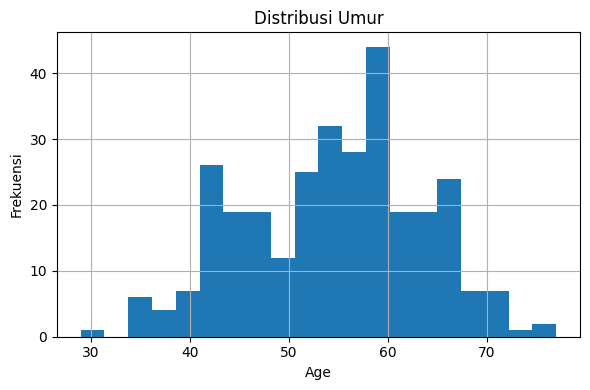

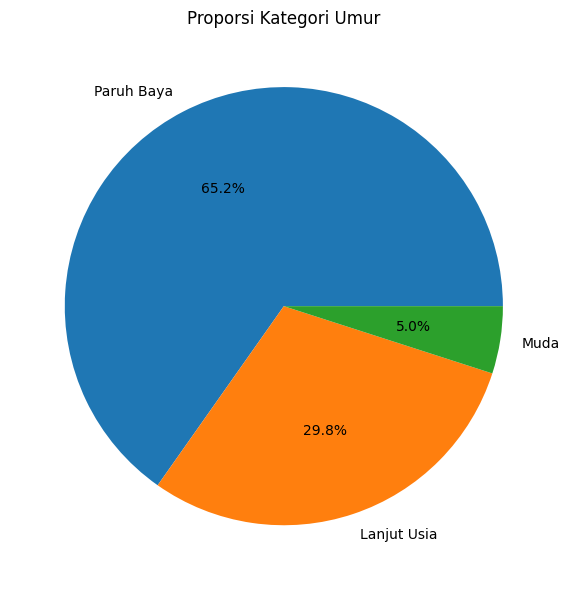

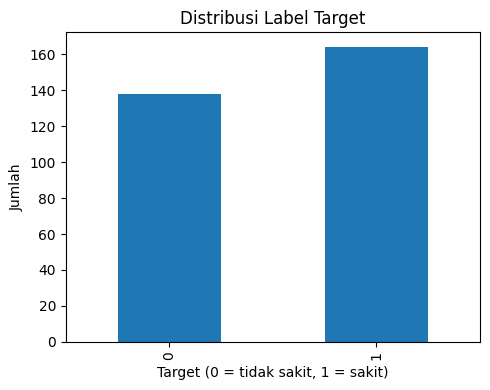

>> Gambar tersimpan di: /content/drive/MyDrive/DataMining2025/artifacts


In [ ]:
# @title 8) Visualisasi ringkas untuk PPT/LinkedIn (satu grafik per plot)

# Histogram umur
if 'age' in df.columns:
    plt.figure(figsize=(6,4))
    df['age'].hist(bins=20)
    plt.title("Distribusi Umur")
    plt.xlabel("Age")
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS_DIR, "hist_age.png"))
    plt.show()

# Pie chart age_category
if 'age_category' in df.columns:
    plt.figure(figsize=(6,6))
    df['age_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title("Proporsi Kategori Umur")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS_DIR, "pie_age_category.png"))
    plt.show()

# Barplot target
if 'target' in df.columns:
    plt.figure(figsize=(5,4))
    df['target'].value_counts().sort_index().plot(kind='bar')
    plt.title("Distribusi Label Target")
    plt.xlabel("Target (0 = tidak sakit, 1 = sakit)")
    plt.ylabel("Jumlah")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS_DIR, "bar_target.png"))
    plt.show()

print(">> Gambar tersimpan di:", ARTIFACTS_DIR)
